# Tests
Test different functions of the library.

In [22]:
# Import the library.
import dsa_helpers as dh
from pathlib import Path
import matplotlib.pyplot as plt
from shutil import rmtree
import json
from transformers import SegformerForSemanticSegmentation

In [26]:
# Constants
DATA_DIR = "data"
DSA_API_URL = "https://computablebrain.emory.edu/api/v1"
DSA_WSI_ITEM_ID = "670fd3e2897872a4bba54097"
DSA_TAU_WSI_ITEM_ID = "670ffe37897872a4bba540cc"
THUMBNAIL_MAG = 2.0
TILE_SIZE = 512
SEGFORMER_SEMANTIC_SEG_MODEL_DIR = "models/segformer-semantic-segmentation"
BATCH_SIZE = 8

In [3]:
# Authenticate girder client.
gc = dh.girder_utils.login(DSA_API_URL)

In [18]:
# Clean up the data directory.
rmtree(DATA_DIR, ignore_errors=True)

## 1.1. Get thumbnail at specified magnification.

In [ ]:
# Read a sample thumbnail from the DSA.
thumbnail_img = dh.girder_utils.get_thumbnail(
    gc, 
    DSA_WSI_ITEM_ID,
    mag=THUMBNAIL_MAG
)[:, :, :3]

plt.imshow(thumbnail_img)
plt.title(f'Thumbnail Image (mag={THUMBNAIL_MAG})')
plt.show()

## 1.2. Tile thumbnail from numpy array.

In [ ]:
# Create location to save tiles.
save_dir = Path(DATA_DIR) / "thumbnail_tile_images"

# Tile the image.
tiles_df = dh.image_utils.tile_image(
    thumbnail_img,
    save_dir, 
    tile_size=TILE_SIZE,
    fill=(114, 114, 114),
    prepend_name="thumbnail",
)

tiles_df.head()

# 2. SegFormer for semantic segmentation inference

Using device: cuda


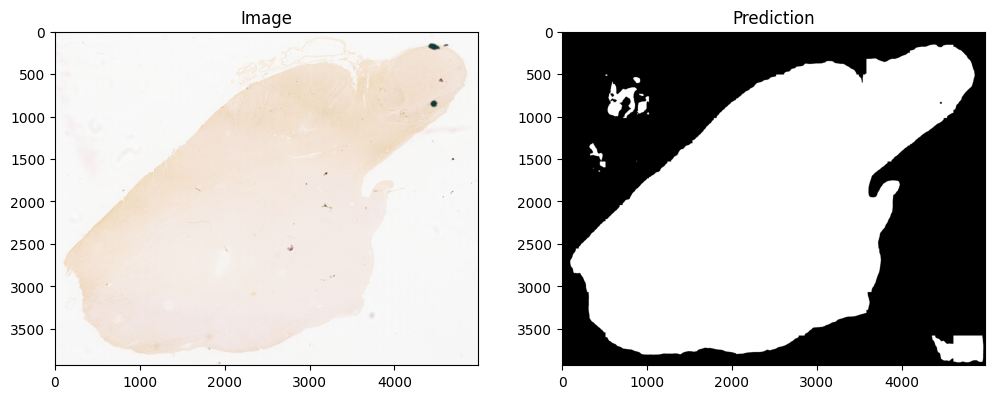

In [27]:
# Check that the model exists.
model_path = Path(SEGFORMER_SEMANTIC_SEG_MODEL_DIR)

if model_path.exists():
    # From the config.json file get the id2label mappings.
    with open(model_path / "config.json", 'r') as fh:
        id2label = json.load(fh)['id2label']
    
# Swamp keys to be integers.
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
    
model = SegformerForSemanticSegmentation.from_pretrained(
    model_path, id2label=id2label, label2id=label2id
)

# Get a thumbnail to predict on.
img = dh.girder_utils.get_thumbnail(
    gc, DSA_TAU_WSI_ITEM_ID, mag=THUMBNAIL_MAG
)[:, :, :3]

# Run inference.
prediction, contour = dh.ml.segformer_semantic_segmentation.inference(
    img,
    model,
    tile_size=TILE_SIZE,
    batch_size=BATCH_SIZE
)

# Plot the image and prediction side by side.
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image")
fig.add_subplot(1, 2, 2)
plt.imshow(prediction, cmap="gray")
plt.title("Prediction")
plt.show()